## Introduction

Since a lot of data can be obtained by downloading csv or excel files, but to avoid the manual download, here the data in the file is downloaded automatically by code.

In [5]:
#install.packages(c("RSelenium", "writexl"))
#install.packages("here")

Installing package into 'C:/Users/user/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



package 'here' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\user\AppData\Local\Temp\RtmpqWX9sO\downloaded_packages


In [1]:

# CPI data
library(magrittr)
library(polite)
library(rvest)
library(here)
library(RSelenium)

here() starts at G:/My Drive/2022/DATA422-S2/assigment group project/project



In [2]:
data_dir = paste(here(), "data", sep = "/")

# session <- bow(
#     "https://www.rbnz.govt.nz/-/media/e3420ae9ec24421bac870e70660d20d0.ashx",
#     user_agent = "polite R package",
#     delay = 5,
#     times = 3,
#     force = FALSE,
#     verbose = FALSE
# )

# rip(session, 
#    destfile = "CPI.xlsx",
#    path = data_dir
#)

eCaps <- list(
  chromeOptions = 
    list(prefs = list(
        "profile.default_content_settings.popups" = 0L,
        "download.prompt_for_download" = FALSE,
        "directory_upgrade" = TRUE,
        "download.default_directory" = data_dir),
      args = list(
        "--disable-blink-features=AutomationControlled"
      )),
      useAutomationExtension = FALSE,
      excludeSwitches = list(
        "enable-automation"
      )
)

rD <- rsDriver(verbose = FALSE, browser = "chrome", chromever = "106.0.5249.61",
                extraCapabilities = eCaps)
remDr <- rD$client
remDr$maxWindowSize()
remDr$navigate("https://infoshare.stats.govt.nz/infoshare/Default.aspx")
# remDr$screenshot(display = TRUE)

# webElem <- remDr$findElement(using = "css", "[data-ga-action='hm1.xlsx'] button")


In [3]:
# Wrapper of remoteDriver$findElement, enable wait and check for 3 times
# rmd:  remote driver client
# p_using: `using` param of findElement
# p_value: `value` param of findElement
get_tree_element <- function(rmd, p_using, p_value) {
    sleep_secs = 2
    vis_check = 0

    # wait for progress valid
    Sys.sleep(sleep_secs)
    while (sleep_secs < 10 & vis_check < 30) {
        vis = remDr$executeScript("return document.getElementById(arguments[0]).style.visibility",
                            args = list("ctl00_MainContent_goProgress", ""))
        # wait for progress finish
        if (vis == "visible") {
            # in progress, keep wait
            vis_check = vis_check + 1
            sleep_secs = 2
            Sys.sleep(sleep_secs)
            next
        } else {
            # wait for element load
           Sys.sleep(sleep_secs) 
        }
        
        try(suppressMessages(rmd$findElement(using = p_using, value = p_value)), silent = TRUE)
        if (rmd$status == 0) {
            elem = rmd$findElement(using = p_using, value = p_value)
            return(elem)
        } else if (remDr$status == 7) {
            # wait for 2 seconds
            Sys.sleep(sleep_secs)
        }
        sleep_secs = sleep_secs * 2
    }
    return(NULL)
}

get_element <- function(rmd, p_using, p_value) {
    sleep_secs = 2

    # wait for progress valid
    Sys.sleep(sleep_secs)
    while (sleep_secs < 10) {
        try(suppressMessages(rmd$findElement(using = p_using, value = p_value)), silent = TRUE)
        if (rmd$status == 0) {
            elem = rmd$findElement(using = p_using, value = p_value)
            return(elem)
        } else if (remDr$status == 7) {
            # wait for 2 seconds
            Sys.sleep(sleep_secs)
        }
        sleep_secs = sleep_secs * 2
    }
    return(NULL)
}

In [4]:
# get into the labour data select panel
elem_lv_one = get_tree_element(remDr, "link text", "Work income and spending")
elem_lv_one$clickElement()

# wait for loading
elem_lv_two = get_tree_element(remDr, "link text",  "Household Labour Force Survey - HLF")
elem_lv_two$clickElement()

elem_lv_three = get_tree_element(remDr, "link text", "Labour Force Status for people aged 15 to 64 years: Seasonally Adjusted (Qrtly-Mar/Jun/Sep/Dec)")
elem_lv_three$clickElement()

In [5]:
season_adj  = get_element(remDr, "css selector", "span#ctl00_MainContent_ctl02_lblSelectAll")
time_range  = get_element(remDr, "css selector", "span#ctl00_MainContent_ctl07_lblSelectAll")
obs_range  = get_element(remDr, "css selector", "span#ctl00_MainContent_ctl04_lblSelectAll")
submit  = get_element(remDr, "css selector", "input#ctl00_MainContent_btnGo")

season_adj$clickElement()
time_range$clickElement()
obs_range$clickElement()
submit$clickElement()

foot = get_element(remDr, "link text", "Footnotes")

page_source = remDr$getPageSource()[[1]]

In [6]:
# parse the page source
doc = xml2::read_html(page_source)
table = doc %>% html_table()

## Data Wrangling & Save

date,Persons Employed in Labour Force,Persons Unemployed in Labour Force,Not in Labour Force,Working Age Population,Labour Force Participation Rate,Unemployment Rate,Employment Rate,Total Labour Force
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1986Q1,"1,594",70,536,"2,200",75.6,4.2,72.4,"1,664"
1986Q2,"1,592",69,541,"2,202",75.4,4.2,72.3,"1,661"
1986Q3,"1,590",70,544,"2,204",75.3,4.2,72.1,"1,660"
1986Q4,"1,581",71,552,"2,204",75.0,4.3,71.7,"1,652"
1987Q1,"1,597",69,546,"2,212",75.3,4.1,72.2,"1,666"
1987Q2,"1,598",70,548,"2,216",75.3,4.2,72.1,"1,668"
1987Q3,"1,599",70,551,"2,221",75.2,4.2,72.0,"1,670"
1987Q4,"1,590",74,556,"2,221",74.9,4.5,71.6,"1,665"
1988Q1,"1,570",83,573,"2,226",74.3,5.0,70.5,"1,653"


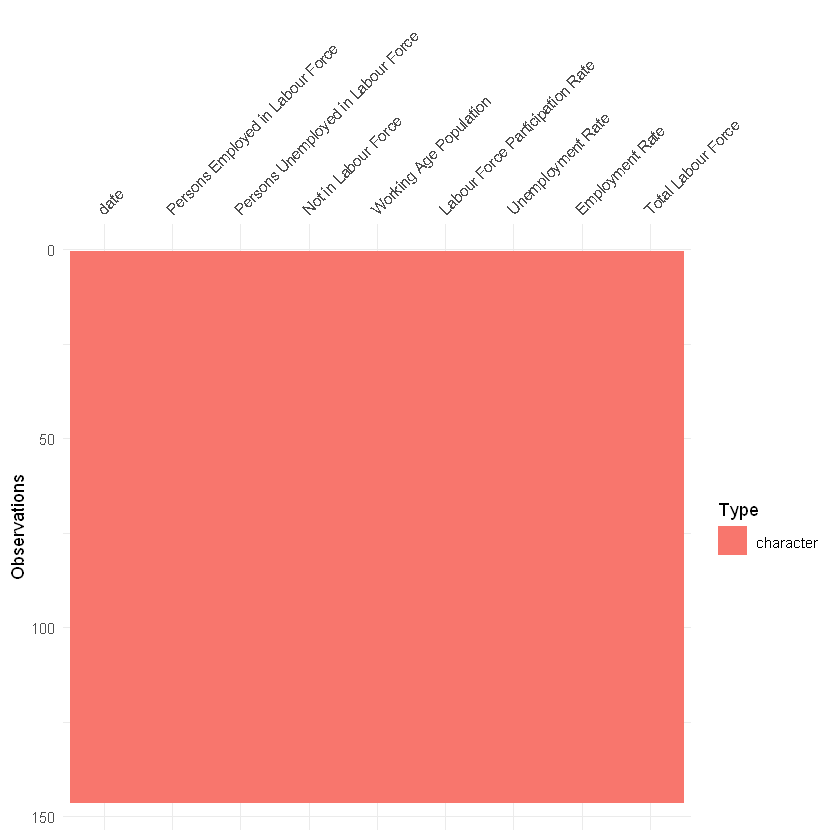

In [7]:
library(visdat)

labour <- table[[8]]
labour[2,1] = "date"
column_name = labour[2,]
colnames(labour) = column_name
labour <- labour[-c(1,2),]
labour

vis_dat(labour)

In [8]:
data_file <- paste(here(), "/labour_force_status.csv")
data_file

[1] "G:/My Drive/2022/DATA422-S2/assigment group project/project /labour_force_status.csv"

In [10]:
library("writexl")
write_xlsx(labour, paste(data_dir, "labour_force_status.csv", sep = "/"))